In [1]:
# !pip install mesa

In [19]:
import enum
import random
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from scipy import stats


import pandas as pd
pd.options.display.max_rows = 150

# Updated source code

In [3]:
class State(enum.IntEnum):  
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2
    DEAD = 3
    VACCINATED = 4

In [13]:
class MyAgent(Agent):
    """An agent in a rudimentary SIRDV model"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)   
        self.state = State.SUSCEPTIBLE  
        self.infection_time = 0
        # Add number of days before a newly-infected person becomes infectious
        self.exposed_time = np.random.normal(5, 2)  
        self.shots = 0  # Keep track of the number of vaccination shots
        
    def move(self):
        """Moves the agent to a new position in the grid"""
        # Dead agents do not move
        if self.state == State.DEAD:
            return
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)


        
    def status(self):
        """
        Checks the infection status of the agent and updates its state based on the following rules:
        - If the agent is infected and has been exposed for longer than their exposed time, they may either die or recover.
        - If the agent is vaccinated, they may become infected if they come into contact with an infected agent.
        """
        if self.state == State.INFECTED and self.model.schedule.time - self.infection_time > self.exposed_time:     
            drate = self.model.death_rate
            alive = np.random.choice([0,1], p=[drate,1-drate])
            if alive == 0:
                self.state = State.DEAD
            else:
                t = self.model.schedule.time-self.infection_time
                if t >= self.recovery_time:          
                    self.state = State.RECOVERED
        elif self.state == State.VACCINATED:
            # If a vaccinated agent comes into contact with an infected agent, there's a chance they could become infected.
            cellmates = self.model.grid.get_cell_list_contents([self.pos])
            if len(cellmates) > 1:
                for other in cellmates:
                    if other.state is State.INFECTED and self.random.random() < self.model.ptrans:
                        self.state = State.INFECTED
                        self.infection_time = self.model.schedule.time
                        self.recovery_time = self.model.get_recovery_time()

    def contact(self):
        """
        This method simulates the contact between agents in a grid. If an agent is dead, it does not come into contact with other agents.
        If an agent is infected and comes into contact with a susceptible agent, the susceptible agent may become infected based on the transmission rate.
        """
        if self.state == State.DEAD:
            return
        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            for other in cellmates:
                # Agents with one shot get partial immunity (reduced transmission rate)
                # while the transmission rates of agents with two shots are cut by 75%
                if self.random.random() > self.model.ptrans * (0.5 if self.shots == 1 else 0.25 if self.shots >= 2 else 1):
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = self.model.get_recovery_time()

    def step(self):
        """
        Performs one step of the agent's life by calling the status, move, and contact methods in order.
        """
        self.status()
        self.move()
        self.contact()

In [14]:
# Modified model class to initiate vaccination after `vaccination_delay` to simulate supply chain issues 
# Vaccination starts after a specified delay and continues at each step. Agents receive one shot at a time. 
# Once an agent has received the required number of shots, their state changes to 'VACCINATED'.

class GridInfectionModel(Model):

    def __init__(self, seed=101, N=10, width=10, height=10, ptrans=0.02, 
                 progression_period=5, progression_sd=2, death_rate=0.00904, recovery_days=14,
                 recovery_sd=7, vaccination_rate=0.02, vaccination_delay=0, shots_needed=2):
        self.seed = seed
        self.num_agents = N
        self.initial_outbreak_size = 1
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
        self.vaccination_rate = vaccination_rate
        self.vaccination_delay = vaccination_delay
        self.shots_needed = shots_needed
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        # Create agents
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            #make some agents infected at start
            infected = np.random.choice([0,1], p=[0.98,0.02])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()
            
        self.datacollector = DataCollector(
            model_reporters={"Total Susceptible": lambda m: self.count_type(m, State.SUSCEPTIBLE),
                             "Total Infected": lambda m: self.count_type(m, State.INFECTED),
                             "Total Recovered": lambda m: self.count_type(m, State.RECOVERED),
                             "Total Dead": lambda m: self.count_type(m, State.DEAD),
                             "Total Vaccinated": lambda m: self.count_type(m, State.VACCINATED)},
            agent_reporters={"State": "state"})

    def get_recovery_time(self):
        """Returns the recovery time for an infected individual"""
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    
    def count_type(self, model, state):
        """Counts the number of agents in a given state"""
        count = 0
        for agent in model.schedule.agents:
            if agent.state is state:
                count += 1
        return count
    
    def step(self):
        """This method performs one step in the model's schedule. 
        Vaccination starts after a specified delay and continues at each step. Agents receive one shot at a time. 
        Once an agent has received the required number of shots, their state changes to 'VACCINATED'."""
        self.datacollector.collect(self)
        self.schedule.step()
        if self.schedule.time >= self.vaccination_delay:
            susceptible_agents = [a for a in self.schedule.agents if a.state is State.SUSCEPTIBLE]
            for a in self.random.sample(susceptible_agents, min(len(susceptible_agents), int(self.vaccination_rate * len(susceptible_agents)))):
                a.shots += 1
                if a.shots >= self.shots_needed:
                    a.state = State.VACCINATED

Parameters:

- `N`: The number of agents in the model. The default is 10,000 agents.
- `width` and `height`: The size of the grid that the agents move around on. The default is 10x10.
- `ptrans`: The probability of transmission of the infection when a susceptible and infected agent come into contact. The default value is 0.002.
- `exposed_time`: controls the number of days that an infected agent is exposed before becoming infectious. When an agent first becomes infected, they are exposed to the disease but not yet able to transmit it to others. The exposed_time represents this incubation period.
- `progression_period` and `progression_sd`: The mean and standard deviation of the normal distribution used to determine the progression period of the infection. In this case, the mean is 5 and the standard deviation is 2. This represents the number of steps it takes for the agent to either recover or die after becoming infected.
- `death_rate`: The probability that an infected agent dies each step. The default is 0.00904.
- `recovery_days` and `recovery_sd`: The mean and standard deviation of the normal distribution used to determine the recovery time of infected agents. In this case, the mean recovery time is 14 days and the standard deviation is 7 days.
- `vaccination_rate`: The proportion of susceptible individuals who get vaccinated each step. The default is 0.05.


# Scenario B - with Incubation Period, NO vaccination delay

In [52]:
# No delay, one run

model2 = GridInfectionModel(seed=101, N=10000, width=10, height=10, ptrans=0.002, 
                           progression_period=5, progression_sd=2, death_rate=0.00904, recovery_days=14,
                           recovery_sd=7, vaccination_rate=0.05, vaccination_delay=0, shots_needed=2)

for i in range(100):
    model2.step()


In [16]:
model_data2 = model2.datacollector.get_model_vars_dataframe()

In [17]:
model_data2

,Total Susceptible,Total Infected,Total Recovered,Total Dead,Total Vaccinated
0,9806,194,0,0,0
1,9757,243,0,0,0
2,9662,309,0,0,29
3,9554,369,3,1,73
4,9402,438,6,1,153
5,9245,518,16,2,219
6,9039,628,26,4,303
7,8840,714,46,4,396
8,8607,814,62,7,510
9,8384,913,85,8,610


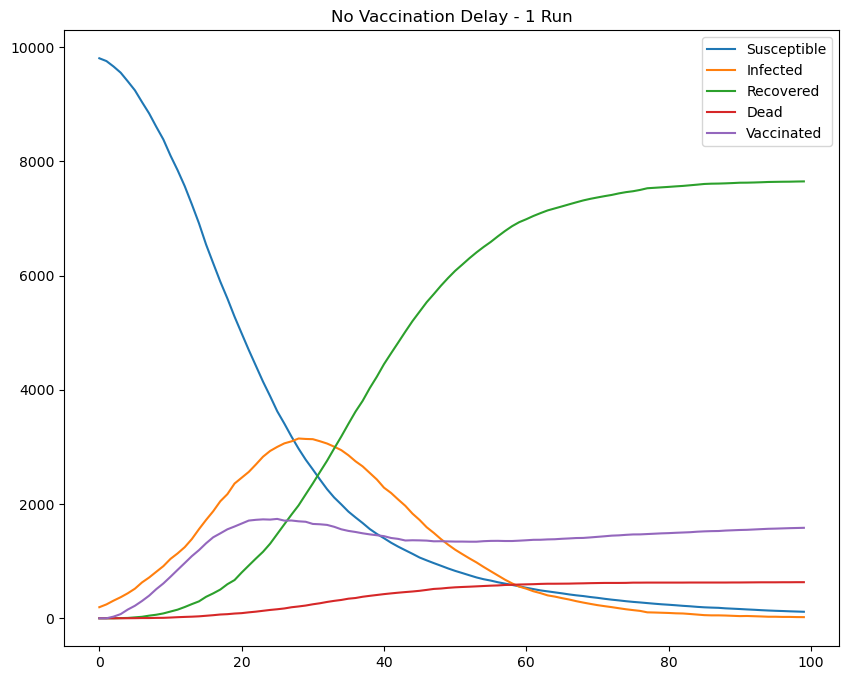

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(model_data2['Total Susceptible'], label='Susceptible')
plt.plot(model_data2['Total Infected'], label='Infected')
plt.plot(model_data2['Total Recovered'], label='Recovered')
plt.plot(model_data2['Total Dead'], label='Dead')
plt.plot(model_data2['Total Vaccinated'], label='Vaccinated')
plt.legend()
plt.title('No Vaccination Delay - 1 Run')
plt.show()

In [33]:
# Peak day of Infection
model_data2[['Total Infected']].idxmax()

Total Infected    28
dtype: int64

In [37]:
# Total Number of agents dead
model_data2[['Total Dead']].max()

Total Dead    632
dtype: int64

# Scenario C - with 30-Day Vaccination Delay, Double Vaccination Rate

In [27]:
# Vaccination delay

model3 = GridInfectionModel(seed=101, N=10000, width=10, height=10, ptrans=0.002, 
                           progression_period=5, progression_sd=2, death_rate=0.00904, recovery_days=14,
                           recovery_sd=7, vaccination_rate=0.10, vaccination_delay=30, shots_needed=2)

for i in range(100):
    model3.step()


In [28]:
model_data3 = model3.datacollector.get_model_vars_dataframe()

In [29]:
model_data3

,Total Susceptible,Total Infected,Total Recovered,Total Dead,Total Vaccinated
0,9781,219,0,0,0
1,9729,271,0,0,0
2,9679,321,0,0,0
3,9627,372,1,0,0
4,9541,455,3,1,0
5,9452,533,12,3,0
6,9343,633,20,4,0
7,9199,760,35,6,0
8,9055,886,51,8,0
9,8885,1016,89,10,0


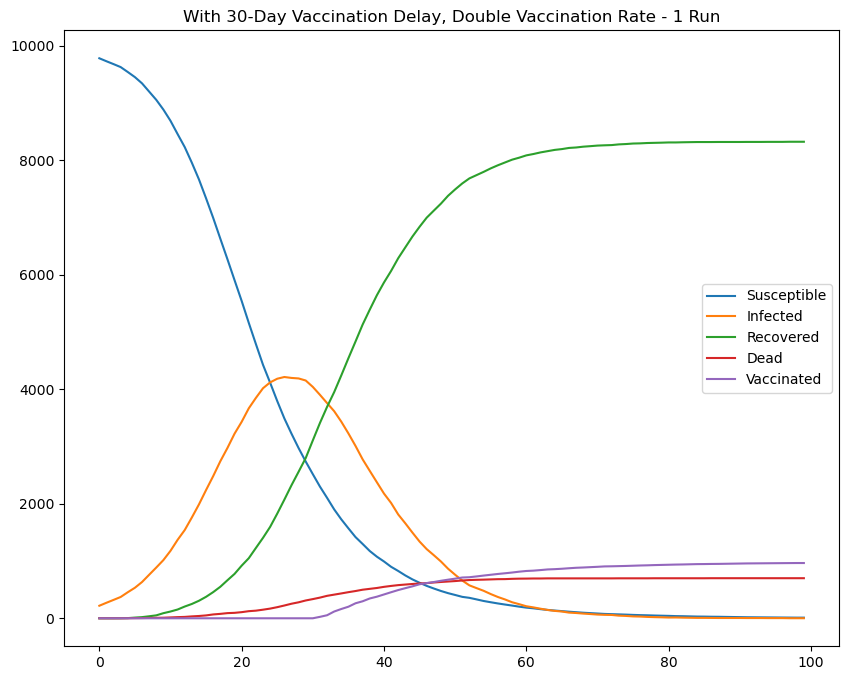

In [31]:
# With 30-Day Vaccination Delay
plt.figure(figsize=(10, 8))
plt.plot(model_data3['Total Susceptible'], label='Susceptible')
plt.plot(model_data3['Total Infected'], label='Infected')
plt.plot(model_data3['Total Recovered'], label='Recovered')
plt.plot(model_data3['Total Dead'], label='Dead')
plt.plot(model_data3['Total Vaccinated'], label='Vaccinated')
plt.legend()
plt.title('With 30-Day Vaccination Delay, Double Vaccination Rate - 1 Run')
plt.show()

In [38]:
# Peak day of Infection
model_data3[['Total Infected']].idxmax()

Total Infected    26
dtype: int64

In [39]:
# Total Number of agents dead
model_data3[['Total Dead']].max()

Total Dead    700
dtype: int64

# Running 50 Independent Replications for Model2

In [40]:
num_reps = 50
model2_rep_data = []

for i in range(num_reps):
    model2_rep = GridInfectionModel(seed = random.seed(i), N=10000, width=10, height=10, ptrans=0.002,  
                              progression_period=5, progression_sd=2, death_rate=0.00904, recovery_days=14,
                              recovery_sd=7, vaccination_rate=0.05, vaccination_delay=0, shots_needed=2)

    for j in range(100):
        model2_rep.step()
    
    model2_rep_data.append(model2_rep.datacollector.get_model_vars_dataframe())

    print(f"Model 2 Replication {i+1} done")

Model 2 Replication 1 done
Model 2 Replication 2 done
Model 2 Replication 3 done
Model 2 Replication 4 done
Model 2 Replication 5 done
Model 2 Replication 6 done
Model 2 Replication 7 done
Model 2 Replication 8 done
Model 2 Replication 9 done
Model 2 Replication 10 done
Model 2 Replication 11 done
Model 2 Replication 12 done
Model 2 Replication 13 done
Model 2 Replication 14 done
Model 2 Replication 15 done
Model 2 Replication 16 done
Model 2 Replication 17 done
Model 2 Replication 18 done
Model 2 Replication 19 done
Model 2 Replication 20 done
Model 2 Replication 21 done
Model 2 Replication 22 done
Model 2 Replication 23 done
Model 2 Replication 24 done
Model 2 Replication 25 done
Model 2 Replication 26 done
Model 2 Replication 27 done
Model 2 Replication 28 done
Model 2 Replication 29 done
Model 2 Replication 30 done
Model 2 Replication 31 done
Model 2 Replication 32 done
Model 2 Replication 33 done
Model 2 Replication 34 done
Model 2 Replication 35 done
Model 2 Replication 36 done
M

In [41]:
# Get number of replications
num_reps = np.shape(model2_rep_data)[0]


# Calculate mean of each variable across replications 
mean_data2_list = []

for i in range(num_reps):
    mean_data2 = []
    
    for col in model2_rep_data[i].columns:
        # We're using max to get the total number of agents per state throughout the simulation
        mean_i = model2_rep_data[i][col].values.max()
        mean_data2.append(mean_i)
    
    mean_data2_list.append(mean_data2)

mean_data2_df = pd.DataFrame(mean_data2_list, columns=[col for col in model2_rep_data[0].columns])
mean_data2_df

,Total Susceptible,Total Infected,Total Recovered,Total Dead,Total Vaccinated
0,9780,3264,7510,662,1691
1,9786,3023,7531,634,1867
2,9784,3032,7327,701,1811
3,9795,3305,7717,646,1695
4,9793,2949,7455,670,1785
5,9834,2853,7404,629,1938
6,9782,3079,7504,633,1721
7,9818,3079,7463,642,1763
8,9826,3094,7562,677,1802
9,9807,3058,7478,614,1760


In [42]:
sample_vals2 = mean_data2_df['Total Dead'].values
sample_mean_death2 = sample_vals2.mean()
sample_mean_death2

656.34

In [43]:
n = num_reps
sample_std_dev = np.sqrt(sum((x - sample_mean_death2) ** 2 for x in sample_vals2) / (n-1))
std_err = sample_std_dev/ np.sqrt(n)
std_err

3.88882333602023

In [44]:
# Calculate the degrees of freedom
dof = n - 1

# Calculate 95% confidence intervals using t-distribution (method 2)
tscore = stats.t.ppf(0.975, dof)
moe = std_err * tscore
ci2 = (sample_mean_death2 - moe, sample_mean_death2 + moe)
ci2

(648.5251169326301, 664.15488306737)

# Running 50 Independent Replications for Model3

In [45]:
num_reps = 40
model3_rep_data = []

for i in range(num_reps):
    
    model3_rep = GridInfectionModel(seed = random.seed(i), N=10000, width=10, height=10, ptrans=0.002, 
                           progression_period=5, progression_sd=2, death_rate=0.00904, recovery_days=14,
                           recovery_sd=7, vaccination_rate=0.10, vaccination_delay=30, shots_needed=2)

    for j in range(100):
        model3_rep.step()
    
    model3_rep_data.append(model3_rep.datacollector.get_model_vars_dataframe())

    print(f"Model 3 Replication {i+1} done")

Model 3 Replication 1 done
Model 3 Replication 2 done
Model 3 Replication 3 done
Model 3 Replication 4 done
Model 3 Replication 5 done
Model 3 Replication 6 done
Model 3 Replication 7 done
Model 3 Replication 8 done
Model 3 Replication 9 done
Model 3 Replication 10 done
Model 3 Replication 11 done
Model 3 Replication 12 done
Model 3 Replication 13 done
Model 3 Replication 14 done
Model 3 Replication 15 done
Model 3 Replication 16 done
Model 3 Replication 17 done
Model 3 Replication 18 done
Model 3 Replication 19 done
Model 3 Replication 20 done
Model 3 Replication 21 done
Model 3 Replication 22 done
Model 3 Replication 23 done
Model 3 Replication 24 done
Model 3 Replication 25 done
Model 3 Replication 26 done
Model 3 Replication 27 done
Model 3 Replication 28 done
Model 3 Replication 29 done
Model 3 Replication 30 done
Model 3 Replication 31 done
Model 3 Replication 32 done
Model 3 Replication 33 done
Model 3 Replication 34 done
Model 3 Replication 35 done
Model 3 Replication 36 done
M

In [46]:
# Get number of replications
num_reps = np.shape(model3_rep_data)[0]


# Calculate mean of each variable across replications 
mean_data3_list = []

for i in range(num_reps):
    mean_data3 = []
    
    for col in model3_rep_data[i].columns:
        mean_i = model3_rep_data[i][col].values.max()
        mean_data3.append(mean_i)
    
    mean_data3_list.append(mean_data3)

mean_data3_df = pd.DataFrame(mean_data3_list, columns=[col for col in model3_rep_data[0].columns])
mean_data3_df

,Total Susceptible,Total Infected,Total Recovered,Total Dead,Total Vaccinated
0,9809,4132,8257,741,989
1,9817,4281,8324,731,934
2,9794,4332,8350,738,901
3,9780,4094,8264,749,974
4,9835,4119,8246,750,993
5,9788,4188,8322,714,950
6,9812,4061,8176,713,1096
7,9794,4166,8282,754,954
8,9819,4090,8287,723,980
9,9797,4218,8291,719,978


In [47]:
sample_vals3 = mean_data3_df['Total Dead'].values
sample_mean_death3 = sample_vals3.mean()
sample_mean_death3

728.475

In [48]:
n = num_reps
sample_std_dev3 = np.sqrt(sum((x - sample_mean_death3) ** 2 for x in sample_vals3) / (n-1))
std_err3 = sample_std_dev3/ np.sqrt(n)
std_err3

2.9869346906408656

In [51]:
# Calculate the degrees of freedom
dof = n - 1

# Calculate 95% confidence intervals using t-distribution (method 2)

tscore = stats.t.ppf(0.975, dof)
moe = std_err3 * tscore
ci3 = (sample_mean_death3 - moe, sample_mean_death3 + moe)
ci3

(722.4333543472956, 734.5166456527045)